In [33]:
import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.inference.base import infer

In [34]:
def MA1(t1, n_obs=100, batch_size=1, random_state=None):
    r"""Generate a sequence of samples from the MA2 model.
    The sequence is a moving average
        x_i = w_i + \theta_1 w_{i-1}
    where w_i are white noise ~ N(0,1).
    Parameters
    ----------
    t1 : float, array_like
    n_obs : int, optional
    batch_size : int, optional
    random_state : RandomState, optional
    """
    # Make inputs 2d arrays for broadcasting with w
    t1 = np.asanyarray(t1).reshape((-1, 1))

    random_state = random_state or np.random

    # i.i.d. sequence ~ N(0,1)
    w = random_state.randn(batch_size, n_obs + 2)
    x = w[:, 2:] + t1 * w[:, 1:-1]
    return x.reshape((batch_size, -1))  # ensure 2D


In [35]:
def stochastic_volatility(w=-0.736,
                          rho=0.9,
                          sigma_v=0.36,
                          n_obs=100,
                          batch_size=1,
                          random_state=None):
    """Sample for a stochastic volatility model.
    specified in Frazier and Drovandi (2021). This is the true Data
    Generating Process for this example.
    Uses a normally distributed shock term.
    Parameters
    ----------
    w : float, optional
    rho : float, optional
    sigma_v : float, optional
    n_obs : int, optional
    batch_size : int, optional
    random_state : RandomState, optional
    Returns
    -------
    y_mat : np.array
    """
    random_state = random_state or np.random

    h_mat = np.zeros((batch_size, n_obs))
    y_mat = np.zeros((batch_size, n_obs))

    w_vec = np.repeat(w, batch_size)
    rho_vec = np.repeat(rho, batch_size)
    sigma_v_vec = np.repeat(sigma_v, batch_size)

    h_mat[:, 0] = w_vec + random_state.normal(0, 1, batch_size) * sigma_v_vec
    y_mat[:, 0] = np.exp(h_mat[:, 0]/2) * random_state.normal(0, 1, batch_size)

    # TODO! CONFIRM CHANGE TO RANGE
    for i in range(1, n_obs):
        h_mat[:, i] = w_vec + rho_vec * h_mat[:, i-1] + \
            random_state.normal(0, 1, batch_size) * sigma_v_vec
        y_mat[:, i] = np.exp(h_mat[:, i]/2)*random_state.normal(0, 1, batch_size)

    return y_mat.reshape((batch_size, -1))  # ensure 2d


In [36]:
def autocov(x, lag=0):
    """Return the autocovariance.
    Assumes a (weak) univariate stationary process with mean 0.
    Realizations are in rows.
    Parameters
    ----------
    x : np.array of size (n, m)
    lag : int, optional
    Returns
    -------
    C : np.array of size (n,)
    """
    x = np.atleast_2d(x)
    # In R this is normalized with x.shape[1]
    if lag == 0:
        C = np.mean(x[:, :] ** 2, axis=1)
    else:
        C = np.mean(x[:, lag:] * x[:, :-lag], axis=1)

    return C


In [37]:
def summstats(x):
    s1 = autocov(x)
    s2 = autocov(x, lag=1)
    return np.array([s1, s2]).reshape(1, -1)

In [38]:
def simulation_wrapper(params):
    x_sim = MA1(params)
    
    sim_sum = torch.as_tensor(summstats(x_sim).astype('float32'))
    return sim_sum.reshape((1, -1))

In [39]:
seed_obs = 1
true_params = [-0.736, 0.9, 0.36]
n_obs = 50

# y = stochastic_volatility(*true_params, n_obs=n_obs,
#                     random_state=np.random.RandomState(seed_obs))
# y

In [40]:
prior_min = [-1]
prior_max = [1]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min),
                                    high=torch.as_tensor(prior_max))

In [41]:
inference = SNLE(prior=prior)

In [42]:
x

tensor([[ 1.0127e+00, -3.2127e-01],
        [ 9.3225e-01, -2.1903e-01],
        [ 1.0812e+00,  2.2605e-02],
        [ 9.8705e-01, -3.1360e-01],
        [ 1.2179e+00, -2.3939e-01],
        [ 1.0583e+00, -3.5181e-01],
        [ 9.8175e-01, -4.7761e-02],
        [ 9.8277e-01,  2.7943e-02],
        [ 1.0465e+00, -1.1765e-01],
        [ 1.0652e+00, -1.1950e-01],
        [ 9.1020e-01, -1.5634e-01],
        [ 1.0778e+00, -3.8108e-01],
        [ 1.0377e+00, -3.8765e-01],
        [ 9.7388e-01, -1.3473e-01],
        [ 1.1745e+00, -2.4027e-01],
        [ 1.5981e+00, -4.6346e-01],
        [ 9.9583e-01, -2.4955e-01],
        [ 9.1260e-01, -9.3207e-02],
        [ 1.1529e+00, -4.1310e-02],
        [ 1.0460e+00, -2.0721e-01],
        [ 1.0487e+00, -4.0401e-01],
        [ 1.0704e+00, -1.1293e-01],
        [ 1.3590e+00, -3.4676e-01],
        [ 1.1847e+00, -4.2640e-01],
        [ 8.4785e-01, -1.0531e-01],
        [ 9.1491e-01,  2.4428e-02],
        [ 1.2656e+00, -9.8769e-02],
        [ 1.5551e+00, -4.967

In [43]:
y = simulation_wrapper(true_params)

num_rounds = 10

posteriors = []
proposal = prior

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulation_wrapper, proposal, num_simulations=500)
    density_estimator = inference.append_simulations(theta, x
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(y)


Running 500 simulations.: 100%|██████████| 500/500 [00:00<00:00, 7576.69it/s]


 Neural network successfully converged after 99 epochs.

Running 500 simulations.: 100%|██████████| 500/500 [00:00<00:00, 3406.28it/s]


 Neural network successfully converged after 57 epochs.

Running 500 simulations.: 100%|██████████| 500/500 [00:00<00:00, 6152.35it/s]


 Neural network successfully converged after 23 epochs.

Running 500 simulations.: 100%|██████████| 500/500 [00:00<00:00, 7742.31it/s]


 Neural network successfully converged after 41 epochs.

Running 500 simulations.: 100%|██████████| 500/500 [00:00<00:00, 4368.46it/s]


 Neural network successfully converged after 23 epochs.

Running 500 simulations.: 100%|██████████| 500/500 [00:00<00:00, 3371.80it/s]


 Neural network successfully converged after 46 epochs.

Running 500 simulations.: 100%|██████████| 500/500 [00:00<00:00, 1021.91it/s]


 Neural network successfully converged after 28 epochs.

Running 500 simulations.: 100%|██████████| 500/500 [00:00<00:00, 12242.28it/s]


 Neural network successfully converged after 42 epochs.

Running 500 simulations.: 100%|██████████| 500/500 [00:00<00:00, 5036.97it/s]


 Neural network successfully converged after 27 epochs.

Running 500 simulations.: 100%|██████████| 500/500 [00:00<00:00, 4982.66it/s]


 Neural network successfully converged after 26 epochs.

In [44]:
samples = posterior.sample((10000,), 
                           x=y)

Generating samples: 100%|██████████| 10000/10000 [24:06<00:00,  6.92it/s]


In [51]:
samples

tensor([[0.1612],
        [0.1953],
        [0.2940],
        ...,
        [0.4859],
        [0.2666],
        [0.2654]])

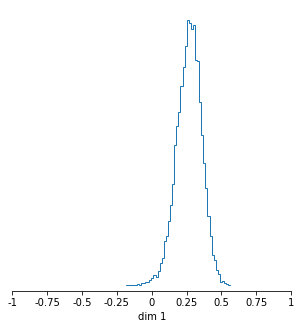

In [50]:
fig, axes = analysis.pairplot(samples,
                           limits=[[-1, 1], [-1, 1]],
                        #    ticks=[[.5, 1], [.5, 15.]],
                           figsize=(5,5),
                        #    points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');